# Binary Classification with R and H2O

### Author: Greg Strabel

This notebook takes a dataset generated by the code [here](https://github.com/Strabes/Data/blob/master/createBinaryClassifierData.py) and fits a gradient boosting binary classifier using H2O. The use of H2O's grid search capability for selecting optimal tuning parameters is also illustrated.

In [1]:
## Load libraries and set options
suppressMessages({
library(data.table)
library(dplyr)
library(ggplot2)
library(gridExtra)
library(h2o)
library(tidyr)
library(caret)
})
options(repr.plot.width = 8, repr.plot.height = 5, repr.plot.res = 100)

In [2]:
## Read in data - see the link above for generating the data
df <- fread('BinaryClassifierData.csv')

In [3]:
## Take a look at the data
df %>% head(10)

Feature: 0,Feature: 1,Feature: 2,Feature: 3,Feature: 4,Feature: 5,Response
A3,B7,C22,0.59602149,0.0417883772,0.67362878,0
A3,B1,C27,0.06570952,0.2696095223,0.88429246,0
A3,B3,C27,0.05997064,0.5630431617,0.76205029,0
A0,B2,C26,0.04782884,0.2894612238,0.91490289,0
A1,B7,C25,0.75214829,0.0010966251,0.02597133,0
A3,B6,C4,0.84756383,0.0001025162,0.23493762,0
A3,B6,C35,0.81963706,0.0009794661,0.08126732,0
A3,B5,C27,0.38951788,0.0629067519,0.24908476,0
A0,B1,C0,0.52420563,0.0623134106,0.05193993,0
A3,B2,C30,0.23378018,0.2666654008,0.39214463,0


In [4]:
## Character variables to factors
glimpse(df)
for(i in names(df)[sapply(df,is.character)]) set(df, j = i, value = as.factor(df[[i]]))
df[,Response := as.factor(Response)]
glimpse(df)

Observations: 200,000
Variables: 7
$ `Feature: 0` <chr> "A3", "A3", "A3", "A0", "A1", "A3", "A3", "A3", "A0", ...
$ `Feature: 1` <chr> "B7", "B1", "B3", "B2", "B7", "B6", "B6", "B5", "B1", ...
$ `Feature: 2` <chr> "C22", "C27", "C27", "C26", "C25", "C4", "C35", "C27",...
$ `Feature: 3` <dbl> 0.59602149, 0.06570952, 0.05997064, 0.04782884, 0.7521...
$ `Feature: 4` <dbl> 0.0417883772, 0.2696095223, 0.5630431617, 0.2894612238...
$ `Feature: 5` <dbl> 0.67362878, 0.88429246, 0.76205029, 0.91490289, 0.0259...
$ Response     <int> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...


Observations: 200,000
Variables: 7
$ `Feature: 0` <fct> A3, A3, A3, A0, A1, A3, A3, A3, A0, A3, A0, A3, A3, A3...
$ `Feature: 1` <fct> B7, B1, B3, B2, B7, B6, B6, B5, B1, B2, B2, B3, B7, B2...
$ `Feature: 2` <fct> C22, C27, C27, C26, C25, C4, C35, C27, C0, C30, C0, C2...
$ `Feature: 3` <dbl> 0.59602149, 0.06570952, 0.05997064, 0.04782884, 0.7521...
$ `Feature: 4` <dbl> 0.0417883772, 0.2696095223, 0.5630431617, 0.2894612238...
$ `Feature: 5` <dbl> 0.67362878, 0.88429246, 0.76205029, 0.91490289, 0.0259...
$ Response     <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


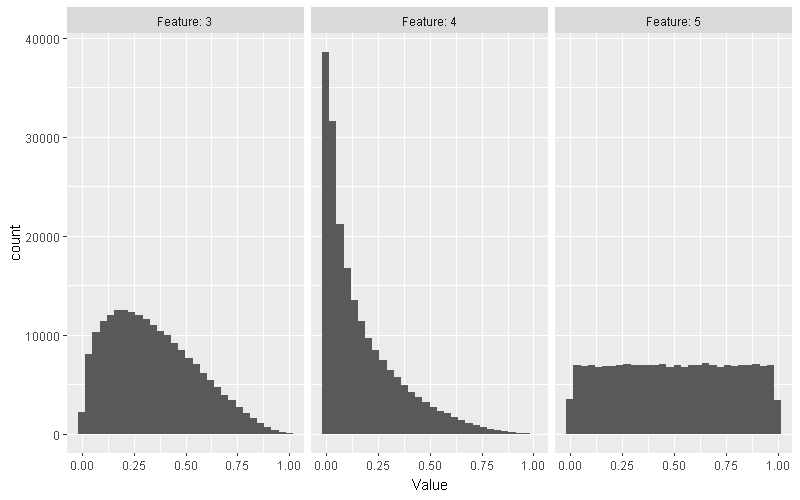

In [5]:
## Histogram the numeric features
df %>% select(`Feature: 3`,`Feature: 4`,`Feature: 5`) %>%
    gather('Feature','Value',1:3) %>%
    ggplot() + geom_histogram(aes(x = Value)) +
    facet_grid(~ Feature)

In [6]:
glimpse(df)

Observations: 200,000
Variables: 7
$ `Feature: 0` <fct> A3, A3, A3, A0, A1, A3, A3, A3, A0, A3, A0, A3, A3, A3...
$ `Feature: 1` <fct> B7, B1, B3, B2, B7, B6, B6, B5, B1, B2, B2, B3, B7, B2...
$ `Feature: 2` <fct> C22, C27, C27, C26, C25, C4, C35, C27, C0, C30, C0, C2...
$ `Feature: 3` <dbl> 0.59602149, 0.06570952, 0.05997064, 0.04782884, 0.7521...
$ `Feature: 4` <dbl> 0.0417883772, 0.2696095223, 0.5630431617, 0.2894612238...
$ `Feature: 5` <dbl> 0.67362878, 0.88429246, 0.76205029, 0.91490289, 0.0259...
$ Response     <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...


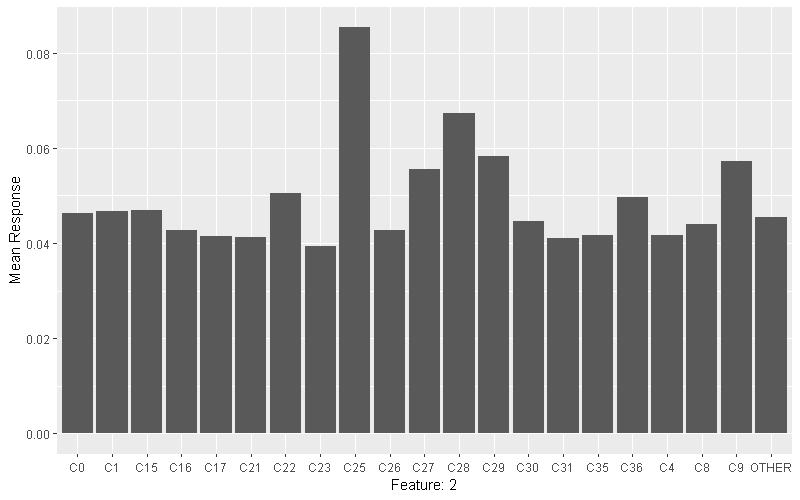

In [7]:
## Mean of response by each of top 20 levels of Feature: 2
df %>%
    group_by(`Feature: 2`) %>%
    mutate(Count = n()) %>%
    ungroup() %>%
    mutate(DR = dense_rank(desc(Count)),
          `Feature: 2` = ifelse(DR <= 20, as.character(`Feature: 2`), 'OTHER')) %>%
    group_by(`Feature: 2`) %>%
    summarise(`Mean Response` = mean(as.numeric(as.character(Response)))) %>%
    ggplot() + geom_bar(aes(x=`Feature: 2`, y=`Mean Response`), stat = 'identity')

In [8]:
## Split data into train, test and validation
set.seed(1)
spec <- c(train = .6, test = .2, validate = .2)
g <- sample(cut(
  seq(nrow(df)), 
  nrow(df)*cumsum(c(0,spec)),
  labels = names(spec)
))
res <- split(df, g)

In [9]:
## Start h2o
h2o.init()


H2O is not running yet, starting it now...

Note:  In case of errors look at the following log files:
    C:\Users\Gregory\AppData\Local\Temp\Rtmpe4yzz5/h2o_Gregory_started_from_r.out
    C:\Users\Gregory\AppData\Local\Temp\Rtmpe4yzz5/h2o_Gregory_started_from_r.err


Starting H2O JVM and connecting: . Connection successful!

R is connected to the H2O cluster: 
    H2O cluster uptime:         4 seconds 407 milliseconds 
    H2O cluster timezone:       America/Denver 
    H2O data parsing timezone:  UTC 
    H2O cluster version:        3.20.0.8 
    H2O cluster version age:    2 months and 5 days  
    H2O cluster name:           H2O_started_from_R_Gregory_unq737 
    H2O cluster total nodes:    1 
    H2O cluster total memory:   1.76 GB 
    H2O cluster total cores:    4 
    H2O cluster allowed cores:  4 
    H2O cluster healthy:        TRUE 
    H2O Connection ip:          localhost 
    H2O Connection port:        54321 
    H2O Connection proxy:       NA 
    H2O Internal Security:

In [10]:
## Read data into h2o
train <- as.h2o(res$train)
test <- as.h2o(res$test)
validate <- as.h2o(res$validate)

  |======================================================================| 100%
  |======================================================================| 100%
  |======================================================================| 100%


In [11]:
## gbm hyperparameters for grid search
hyper_params = list(ntrees= c(100,150,200),
                    max_depth= c(2,4,8),
                    learn_rate = c(0.05, 0.1, 0.2),
                    learn_rate_annealing = c(0.99,0.95))

In [12]:
## Grid search the gbm
gbm.grid <- h2o.grid(algorithm = 'gbm',
                     grid_id = 'gbm.grid',
                     y='Response',
                     x=names(train)[names(train) != 'Response'],
                     training_frame = train,
                     validation_frame = test,
                     hyper_params = hyper_params,
                     distribution = 'bernoulli',
                     seed = 1)

  |======================================================================| 100%


In [13]:
## Get grid results
gridResults <- h2o.getGrid(grid_id = 'gbm.grid',sort_by = 'logloss',decreasing = FALSE)

In [14]:
## Print grid results
gridResults

H2O Grid Details

Grid ID: gbm.grid 
Used hyper parameters: 
  -  learn_rate 
  -  learn_rate_annealing 
  -  max_depth 
  -  ntrees 
Number of models: 54 
Number of failed models: 0 

Hyper-Parameter Search Summary: ordered by increasing logloss
  learn_rate learn_rate_annealing max_depth ntrees         model_ids
1        0.1                 0.99         4    200 gbm.grid_model_43
2        0.1                 0.99         4    150 gbm.grid_model_25
3        0.1                 0.99         4    100  gbm.grid_model_7
4       0.05                 0.99         4    200 gbm.grid_model_42
5        0.2                 0.95         4    200 gbm.grid_model_47
              logloss
1 0.19394601646043036
2 0.19394601646043036
3 0.19394948413942698
4 0.19397636565313062
5 0.19401692624708788

---
   learn_rate learn_rate_annealing max_depth ntrees         model_ids
49        0.1                 0.95         2    200 gbm.grid_model_40
50        0.1                 0.95         2    150 gbm.grid_m

In [15]:
## Get best gbm
# best gbm parameters:
# learn_rate: 0.1
# learn_rate_anneaaling = 0.99
# max_depth: 4
# ntrees: 150
best_gbm <- h2o.getModel(gridResults@model_ids[[1]])

In [16]:
## Save best gbm
h2o.saveModel(best_gbm,path = 'C:/Users/Gregory/Documents/PythonScripts/h2oExample_R.best_gbm')

[1] "C:\\Users\\Gregory\\Documents\\PythonScripts\\h2oExample_R.best_gbm\\gbm.grid_model_43"

In [17]:
## Save grid search results
capture.output(gridResults,file = 'h2oExample_R.best_gbm/gridResults.txt')

In [18]:
## Score validation data
validation_preds <- h2o.cbind(validate, h2o.predict(object = best_gbm, newdata = validate))

  |======================================================================| 100%


In [19]:
validation_preds <- as.data.frame(validation_preds)

In [20]:
glimpse(validation_preds)

Observations: 40,000
Variables: 10
$ Feature..0 <fct> A0, A3, A3, A0, A0, A3, A3, A0, A3, A3, A0, A3, A0, A3, ...
$ Feature..1 <fct> B2, B6, B6, B3, B5, B3, B7, B2, B5, B5, B2, B2, B2, B4, ...
$ Feature..2 <fct> C26, C4, C35, C25, C5, C29, C29, C27, C26, C17, C0, C17,...
$ Feature..3 <dbl> 0.04782884, 0.84756383, 0.81963706, 0.60812662, 0.690586...
$ Feature..4 <dbl> 0.2894612238, 0.0001025162, 0.0009794661, 0.3722057421, ...
$ Feature..5 <dbl> 0.91490289, 0.23493762, 0.08126732, 0.04573417, 0.379366...
$ Response   <fct> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0,...
$ predict    <fct> 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,...
$ p0         <dbl> 0.9777136, 0.9828889, 0.9837783, 0.9134452, 0.9174010, 0...
$ p1         <dbl> 0.022286443, 0.017111065, 0.016221671, 0.086554755, 0.08...


In [21]:
## Function to calculate ROC curve
simple_roc <- function(labels, scores){
  labels <- labels[order(scores, decreasing=TRUE)]
  data.frame(TPR=cumsum(labels)/sum(labels), FPR=cumsum(!labels)/sum(!labels), labels)
}

In [22]:
## Calculate ROC curve
roc_df <- simple_roc(as.numeric(as.character(validation_preds$Response)),validation_preds$p1)

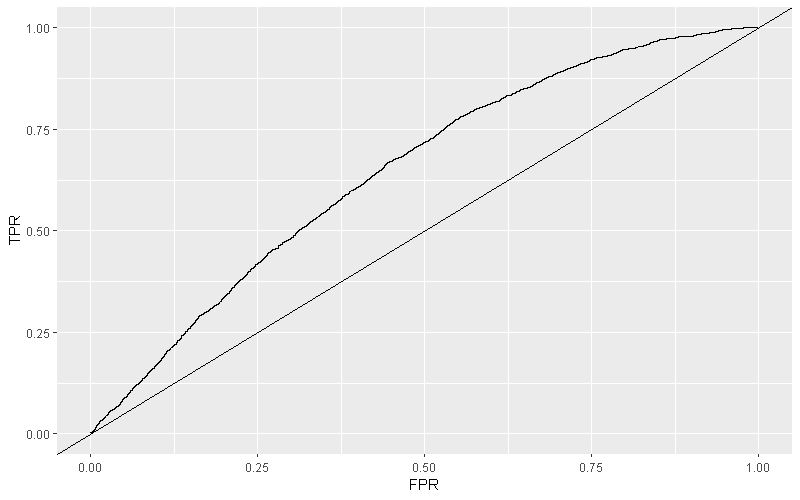

In [23]:
## Plot the ROC curve
ggplot(roc_df) + geom_line(aes(x=FPR, y= TPR)) +
geom_abline()

In [24]:
# Display the confusion matrix and classification report
print(confusionMatrix(validation_preds$predict,validation_preds$Response))

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0 27729  1080
         1 10305   886
                                          
               Accuracy : 0.7154          
                 95% CI : (0.7109, 0.7198)
    No Information Rate : 0.9508          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.0557          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.72906         
            Specificity : 0.45066         
         Pos Pred Value : 0.96251         
         Neg Pred Value : 0.07917         
             Prevalence : 0.95085         
         Detection Rate : 0.69322         
   Detection Prevalence : 0.72023         
      Balanced Accuracy : 0.58986         
                                          
       'Positive' Class : 0               
                                          


In [25]:
# Take a look at the default decision threshold selected by H2O
validation_preds %>%
group_by(predict) %>%
summarise(maxp0 = max(p0),
         minp0 = min(p0),
         maxp1 = max(p1),
         minp1 = min(p1))

predict,maxp0,minp0,maxp1,minp1
0,0.9967427,0.9324125,0.06758751,0.003257266
1,0.9324088,0.5402180,0.45978202,0.067591249


In [26]:
# Calculate the Normalized Weighted Gini for the classifier
WeightedGini <- function(solution, weights, submission){
    df = data.frame(solution = solution, weights = weights, submission = submission)
    df <- df[order(df$submission, decreasing = TRUE),]
    df$random = cumsum((df$weights/sum(df$weights)))
    totalPositive <- sum(df$solution * df$weights)
    df$cumPosFound <- cumsum(df$solution * df$weights)
    df$Lorentz <- df$cumPosFound / totalPositive
    n <- nrow(df)
    gini <- sum(df$Lorentz[-1]*df$random[-n]) - sum(df$Lorentz[-n]*df$random[-1])
    return(gini)
}

NormalizedWeightedGini <- function(solution, weights, submission) {
    WeightedGini(solution, weights, submission) / WeightedGini(solution, weights, solution)
}

nwg <- NormalizedWeightedGini(validation_preds$Response %>%
                       as.character() %>%
                       as.numeric(),
                       rep(1,nrow(validation_preds)),
                       validation_preds$p1)

print(paste0('Normalized Gini: ',nwg))

[1] "Normalized Gini: 0.294934670810258"


In [27]:
# Shutdown the H2O instance
h2o.shutdown()

Are you sure you want to shutdown the H2O instance running at http://localhost:54321/ (Y/N)? Y


[1] TRUE